# Importing the necessary libraries

In [1]:
import os
from random import shuffle
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.datasets as datasets
import time
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Defining the transforms to apply on the dataset and defining the data loader

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets


batch_size = 64
num_workers = 4  
pin_memory = True  # Enable for faster data transfer if using GPU
dataset = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/train', transform=data_transforms)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
dataset_val = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/val', transform=data_transforms)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
dataset_test = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/test', transform=data_transforms)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)



"""
batch_size = 128 #512
num_workers = 4  
pin_memory = True  # Enable for faster data transfer  if using GPU

def limit_dataset(dataset, max_per_class=2000):
    #Crea un subconjunto del dataset con un máximo de imágenes por clase.
    class_indices = {}
    
    # Organizar las imágenes por clase
    for idx, (_, label) in enumerate(dataset.samples):
        if label not in class_indices:
            class_indices[label] = []
        if len(class_indices[label]) < max_per_class:
            class_indices[label].append(idx)
    
    # Unir los índices seleccionados en una sola lista
    selected_indices = [idx for indices in class_indices.values() for idx in indices]
    
    # Crear el subconjunto con las imágenes seleccionadas
    return Subset(dataset, selected_indices)

# Cargar datasets completos
dataset = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/train', transform=data_transforms)
dataset_val = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/val', transform=data_transforms)
dataset_test = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/test', transform=data_transforms)

# Reducir cada dataset a máximo 2000 imágenes por clase
train_subset = limit_dataset(dataset, max_per_class=6000)
val_subset = limit_dataset(dataset_val, max_per_class=6000)
test_subset = limit_dataset(dataset_test, max_per_class=6000)

# DataLoaders con los datasets reducidos
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
"""

"\nbatch_size = 128 #512\nnum_workers = 4  \npin_memory = True  # Enable for faster data transfer  if using GPU\n\ndef limit_dataset(dataset, max_per_class=2000):\n    #Crea un subconjunto del dataset con un máximo de imágenes por clase.\n    class_indices = {}\n    \n    # Organizar las imágenes por clase\n    for idx, (_, label) in enumerate(dataset.samples):\n        if label not in class_indices:\n            class_indices[label] = []\n        if len(class_indices[label]) < max_per_class:\n            class_indices[label].append(idx)\n    \n    # Unir los índices seleccionados en una sola lista\n    selected_indices = [idx for indices in class_indices.values() for idx in indices]\n    \n    # Crear el subconjunto con las imágenes seleccionadas\n    return Subset(dataset, selected_indices)\n\n# Cargar datasets completos\ndataset = datasets.ImageFolder(root='C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/data/data/train', transform=data_transforms)\ndataset_val = d

# Checking if a GPU is available, else training on CPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Training on {torch.cuda.get_device_name()}")
else:
    print(f"Training on CPU")

Training on NVIDIA GeForce GTX 1650


# Defining the resnet 34 Model from torch vision

In [5]:
if not os.path.exists("resnet34"):
    os.mkdir("resnet34")


# Define ResNet-152 model
model = resnet34(weights=ResNet34_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\yoyos/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:55<00:00, 1.59MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Defining the loss function and Optimizer as adamW
We will using a learning schedular which decays if val loss does not reduce for a few epochs

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

c:\Users\yoyos\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Model Training

In [7]:
#num_epochs = 40
num_epochs = 10
best_val_accuracy = 0.0


csv_filename = "resnet34/training_log.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy", "Time (s)"])

# Initialize variables for best model tracking
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy for this epoch
    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy for this epoch
    val_accuracy = 100 * correct_val / total_val
    scheduler.step(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    # Print and log epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, " 
          f"Val Loss: {val_loss/len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

    # Log results to CSV file
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, running_loss/len(train_loader), val_loss/len(val_loader), train_accuracy, val_accuracy, epoch_time])

    # Check if this is the best model so far based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_epoch = epoch + 1
        # Save the best model checkpoint
        best_model_path = f"resnet34/best.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, best_model_path)

torch.save(model.state_dict(), "resnet34/last.pt")
print("Training complete")

Epoch 1/10, Training Loss: 0.3185, Val Loss: 0.2434, Train Accuracy: 88.01%, Val Accuracy: 90.86%, Time: 3188.72 seconds
Epoch 2/10, Training Loss: 0.2077, Val Loss: 0.1756, Train Accuracy: 92.19%, Val Accuracy: 93.42%, Time: 3229.49 seconds
Epoch 3/10, Training Loss: 0.1657, Val Loss: 0.1972, Train Accuracy: 93.77%, Val Accuracy: 92.50%, Time: 3197.45 seconds
Epoch 4/10, Training Loss: 0.1387, Val Loss: 0.1607, Train Accuracy: 94.80%, Val Accuracy: 93.95%, Time: 3192.09 seconds
Epoch 5/10, Training Loss: 0.1186, Val Loss: 0.1564, Train Accuracy: 95.53%, Val Accuracy: 94.21%, Time: 3190.89 seconds
Epoch 6/10, Training Loss: 0.1027, Val Loss: 0.1477, Train Accuracy: 96.14%, Val Accuracy: 94.45%, Time: 3197.33 seconds
Epoch 7/10, Training Loss: 0.0915, Val Loss: 0.1482, Train Accuracy: 96.55%, Val Accuracy: 94.56%, Time: 3185.96 seconds
Epoch 8/10, Training Loss: 0.0802, Val Loss: 0.1481, Train Accuracy: 96.98%, Val Accuracy: 94.71%, Time: 3172.86 seconds
Epoch 9/10, Training Loss: 0.073

# Loading the best weights and evaluating on the test set

In [8]:
# Load the best model checkpoint for testing
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])


C:\Users\yoyos\AppData\Local\Temp\ipykernel_28136\2956843309.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


<All keys matched successfully>

Test Loss: 0.1467, Test Accuracy: 94.60%


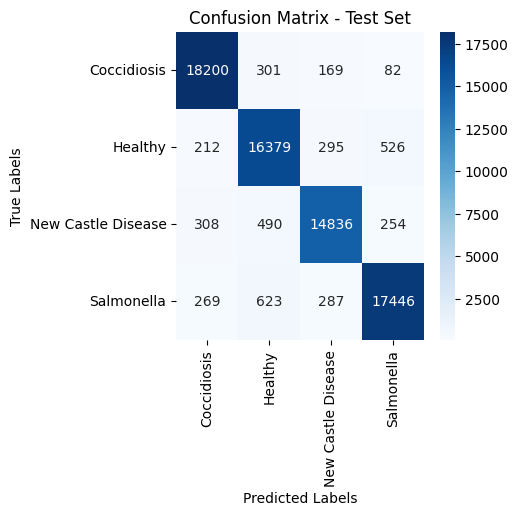

Confusion matrix saved as confusion_matrix.png


In [9]:
# Testing
model.eval()
class_labels = dataset.classes
correct_test = 0
total_test = 0
test_loss = 0.0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute and plot the confusion matrix for the final test set
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(len(class_labels), len(class_labels)))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set")
plt.savefig("resnet34/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("Confusion matrix saved as confusion_matrix.png")

In [10]:
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

                    precision    recall  f1-score   support

       Coccidiosis       0.96      0.97      0.96     18752
           Healthy       0.92      0.94      0.93     17412
New Castle Disease       0.95      0.93      0.94     15888
        Salmonella       0.95      0.94      0.94     18625

          accuracy                           0.95     70677
         macro avg       0.95      0.95      0.95     70677
      weighted avg       0.95      0.95      0.95     70677



## Gradcam resnet 34

In [13]:
pip install torchcam matplotlibA


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlibA (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for matplotlibA


In [14]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import os
import random

# Configura el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga la arquitectura base
model = models.resnet34(weights=None)  # SIN pesos por defecto
model.fc = nn.Linear(model.fc.in_features, 4)  # Asegúrate que coincida con tus clases
model.load_state_dict(torch.load("C:/Users/yoyos/Documents/OCTAVO/Machine Learning 2/proyecto_final/resnet34/resnet34/best.pt")["model_state_dict"])
model.to(device)
model.eval()


C:\Users\yoyos\AppData\Local\Temp\ipykernel_28136\1140127558.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/yoyos/Documents/

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

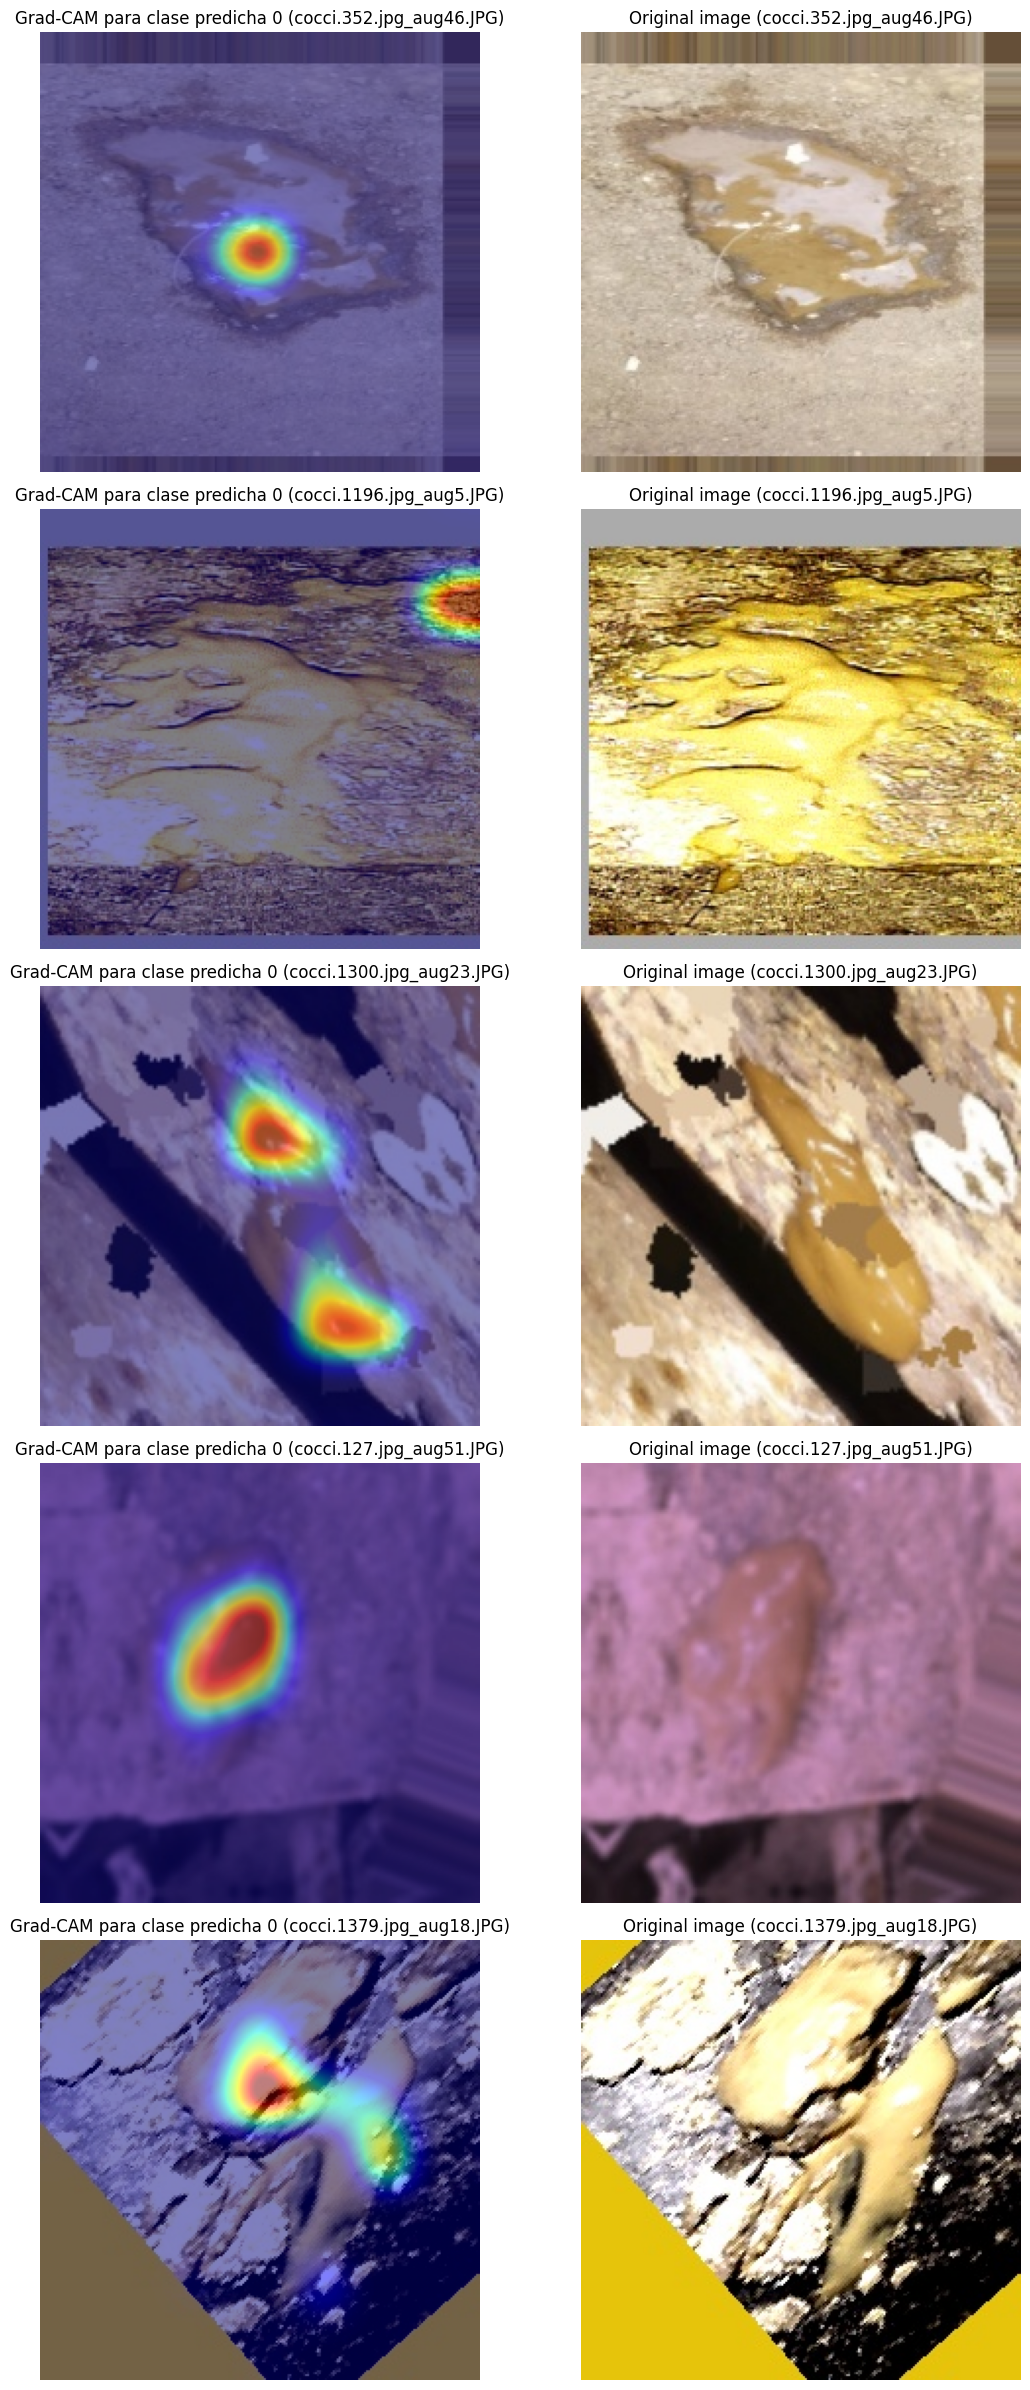

In [16]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# Transforms igual a entrenamiento
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ruta de carpeta con imágenes de Coccidiosis
coccidiosis_dir = r"C:\Users\yoyos\Documents\OCTAVO\Machine Learning 2\proyecto_final\data\data\train\Coccidiosis"

# Crear figura con espacio para 5 subgráficas (2 filas, 5 columnas)
fig, axes = plt.subplots(5, 2, figsize=(12, 24))

# Para cada imagen en la selección aleatoria
for i in range(5):
    # Selección aleatoria de imagen
    img_name = random.choice(os.listdir(coccidiosis_dir))
    img_path = os.path.join(coccidiosis_dir, img_name)

    # Cargar la imagen
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Aplica Grad-CAM
    cam_extractor = GradCAM(model, target_layer='layer4')  # Última capa conv
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Extrae el mapa de activación
    activation_map = cam_extractor(pred_class, output)

    # Convierte el mapa de activación a imagen PIL (normalizado a [0, 1])
    activation_img = to_pil_image(activation_map[0].cpu(), mode='F')  # 'F' = float32
    result = overlay_mask(img, activation_img, alpha=0.5)

    # Mostrar la imagen Grad-CAM en la primera columna de cada fila
    axes[i, 0].imshow(result)
    axes[i, 0].set_title(f"Grad-CAM para clase predicha {pred_class} ({img_name})")
    axes[i, 0].axis("off")

    # Mostrar la imagen original en la segunda columna de cada fila
    axes[i, 1].imshow(img)
    axes[i, 1].set_title(f"Original image ({img_name})")
    axes[i, 1].axis("off")

# Ajustar el espacio entre las subgráficas
plt.tight_layout()

# Mostrar todas las imágenes
plt.show()
